Bilayer unit domain. Sigma optimisation

In [350]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, assemble_scalar
import basix
from dolfinx.geometry import bb_tree
from dolfinx import geometry
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [351]:
# # Define element size for the mesh refinement
# h = 0.125/4   # N=1

# # Domain configuration
# Lx = 1. # fluid domain length (without PML)
# l_inner=Lx/2

# # Physical configuration
# rho_media_1 = 1. # kg/m^3 
# vel_media_1 = 2.   # m/s
# rho_media_2 = 1. # kg/m^3 
# vel_media_2 = 1.   # m/s

# # Define the density and velocity functions  
# def rho_function(x):    
#     return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

# def vel_function(x):    
#     return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# # PML configuration
# pml_thickness = Lx/8

# # Solver configuration
# requested_eigenvalues_number = 10 # Number of eigenvalues to compute

# degree=[2,1]  # Polynomial degree for pressure and velocity
# sigma_sweep_quadratic=np.linspace(10., 5000., 10)
# target=[-12.56j, 
#         -50.26j] # Shifts for the eigensolvers

In [352]:
# Define element size for the mesh refinement
h = 0.125/4   # N=1

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2 # position of the interface between both media

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/8

# Solver configuration
requested_eigenvalues_number = 25 # Number of eigenvalues to compute
target=[-20.5j] # Target for the shift-and-invert spectral transformation
degree=[3,2]  # Polynomial degree for pressure and velocity

# sigma_sweep_quadratic=np.linspace(10., 5000., 10)
# sigma_sweep=np.linspace(1., 100., 10) #piecewise
sigma_sweep = np.arange(1, 201, 11)
pml_type='piecewise'

Solver configuration and computing

In [353]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(target)  
    solver.solve()
    n_eigs_converged = solver.getConverged()

    return solver, mesh, Q, V, dof

In [354]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    return p_h, v_h

In [355]:
def get_exact_eigenpair(selected_index, Q, V, x_hat, sigma_x, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] > l_inner, p_2(x), p_1(x))

    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., sigma_x(x))

    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] > l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

In [356]:
def project_exact_to_mesh(u_exact, Vh):
    """
    Proxecta/interpola unha expresión exacta (UFL) ou un Function
    doutra malla ao espazo funcional Vh (malla actual).

    Funciona en dolfinx 0.9 e evita todos os problemas de dimensión
    e de Expression nos MixedElements.
    """

    # Se u_exact xa é un Function no mesmo espazo, devolver directamente
    if isinstance(u_exact, Function) and u_exact.function_space == Vh:
        return u_exact

    # Crear Function sobre Vh
    u_proj = Function(Vh)

    # Caso 1: exacta é Function doutra malla -> interpolar
    if isinstance(u_exact, Function):
        u_proj.interpolate(u_exact)
        return u_proj

    # Caso 2: exacta é UFL Expression -> interpolar mediante Expression
    # Obter puntos de interpolación (DOF coordinates)
    X = Vh.tabulate_dof_coordinates()

    # Se é 1D pero X ven con máis dimensións, quedar coa primeira columna
    if X.ndim == 2 and X.shape[1] > 1:
        X = X[:, :1]

    expr = Expression(u_exact, X, dtype=u_proj.x.array.dtype)
    u_proj.interpolate(expr)

    return u_proj


In [357]:
def eigenvector_L2_error_physical(u_num, u_exact, Lx, mesh):
    """
    Erro relativo L2 só no dominio físico [0, Lx] en DOLFINx 0.9.
    Alinea fase/signo antes de medir o erro.
    """

    import numpy as np
    import ufl
    from ufl import inner
    from dolfinx.mesh import locate_entities, meshtags
    from dolfinx.fem import form, assemble_scalar

    
    tdim = mesh.topology.dim

    # --- 1) Localizar celas físicas ---
    cells_phys = locate_entities(
        mesh, tdim,
        lambda x: np.logical_and(x[0] >= 0, x[0] < Lx)
    )

    if len(cells_phys) == 0:
        raise RuntimeError("Non se detectaron celas na rexión física [0, Lx].")

    # Asignar etiqueta 1
    values = np.full(len(cells_phys), 1, dtype=np.int32)
    mt = meshtags(mesh, tdim, cells_phys, values)

    # Medida restrinxida
    dx_phys = ufl.Measure("dx", domain=mesh, subdomain_data=mt)
    
    # --- 3) Norma L2 do erro no dominio físico ---
    diff = u_num - u_exact

    num = np.sqrt(assemble_scalar(form(inner(diff, diff) * dx_phys(1))))
    den = np.sqrt(assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1))))

    return num / den


In [358]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [359]:
def normalize_at_Lx(u, bb, Lx, mesh):
    val_Lx = eval_point_fast(u, bb, Lx, mesh)
    u.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return u

In [360]:
def  get_ten_first_approx_eigenpair(exact_eigenvalue_idx, solver, Q, V, dof, sigma_i, mesh):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    p_h:    Function
    v_h: Function
    """
    p_exact = [None]  # Almacena los autovectores exactos de presión
    v_exact = [None]   # Almacena los autovectores exactos de velocidad
    err_p = []
    err_v = []
    err_eig = []
    err = []
    approx_p = []
    approx_v = []
    approx_eig = []

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv >= 10:
        nconv=10

    # Vector temporal para extraer Eigenpairs
    vrA, vi = solver.getOperators()[0].getVecs()
    
    #quadratic
    # x_hat=lambda x, w: (x[0]+ (np.abs(x[0]) >= Lx)* np.sign(x[0])* 1j/ w* sigma_i* (np.abs(x[0]) - Lx) ** 3/ (3 * pml_thickness**2))
    # sigma_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
    # gamma_x = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
    
    #piecewise
    sigma_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_i 
    gamma_x = lambda x, w: 1 + (np.abs(x[0]) >= Lx) * (1j / w) * sigma_i + x[0]*0.0
    x_hat = lambda x, w: np.where(x[0] >= Lx, x[0] + (1j / w) * sigma_i * (x[0] - Lx), x[0])

    [eig_exact, p_exact, v_exact] =   get_exact_eigenpair(exact_eigenvalue_idx, Q, V, x_hat, sigma_py, gamma_x)

    bb = bb_tree(mesh, mesh.topology.dim)
    for k in range(nconv):
        omega=solver.getEigenvalue(k) * 1j
        approx_eig.append(omega)
        solver.getEigenpair(k, vrA)  
        # Vector temporal para extraer Eigenpairs
        p_h = Function(Q, name="p_h")
        v_h = Function(V, name="v_h")
        [p_h, v_h]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

        # --- autovalores ---
        err_eig.append(abs(omega - eig_exact) / abs(eig_exact))

        # --- autovectores ---

        p_h=normalize_at_Lx(p_h, bb, Lx, mesh)
        approx_p.append(p_h)
        v_h=normalize_at_Lx(v_h, bb, Lx, mesh)
        approx_v.append(v_h)
        p_exact=normalize_at_Lx(p_exact, bb, Lx, mesh)
        v_exact=normalize_at_Lx(v_exact, bb, Lx, mesh)


        # Errores L2 en dominio físico
        err_p.append(eigenvector_L2_error_physical(p_h, p_exact, Lx, mesh))
        err_v.append(eigenvector_L2_error_physical(v_h, v_exact, Lx, mesh))

        # Total
        err.append(abs(omega - eig_exact) / abs(eig_exact) + eigenvector_L2_error_physical(p_h, p_exact, Lx, mesh) + eigenvector_L2_error_physical(v_h, v_exact, Lx, mesh))
        

        

    return eig_exact, p_exact, v_exact, approx_eig, approx_p, approx_v, err_eig, err_p, err_v, err


In [361]:
results_sigma = {}

# Crear nova malla para este refinamento
mesh = create_interval(
    MPI.COMM_WORLD,
    int((Lx + pml_thickness) / h),
    [0, Lx + pml_thickness]
)
bb = bb_tree(mesh, mesh.topology.dim)
for i, sigma_i in enumerate(sigma_sweep):
    #quadratic sigma_ufl = lambda x: conditional(x[0] > Lx, sigma_i * (x[0] - Lx)**2 / (pml_thickness**2), 0.0)
    sigma_ufl = lambda x: conditional(x[0] > Lx, sigma_i, 0.0) #piecewise
    # configurar problemas
    solver_target_0, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_ufl, target[0])

    # solver_target_3, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_ufl, target[1])

    # modo 0
    out_0 = get_ten_first_approx_eigenpair(1, solver_target_0, Q_, V_, dof_, sigma_i, mesh)
    # modo 3
    # out_3 = get_ten_first_approx_eigenpair(4, solver_target_3, Q_, V_, dof_, sigma_i, mesh)
    # guardar resultados
    results_sigma[sigma_i] = {
        0: {
            'eig_exact':   out_0[0],
            'p_exact':     out_0[1],
            'v_exact':     out_0[2],
            'eig_approx':  out_0[3],
            'p_approx':    out_0[4],
            'v_approx':    out_0[5],
            'err_eig':     out_0[6],
            'err_p':       out_0[7],
            'err_v':       out_0[8],
            'err_total':   out_0[9],
        },
        # 3: {
        #     'eig_exact':   out_3[0],
        #     'p_exact':     out_3[1],
        #     'v_exact':     out_3[2],
        #     'eig_approx':  out_3[3],
        #     'p_approx':    out_3[4],
        #     'v_approx':    out_3[5],
        #     'err_eig':     out_3[6],
        #     'err_p':       out_3[7],
        #     'err_v':       out_3[8],
        #     'err_total':   out_3[9],
        # }
    }



In [362]:
def plot_mode_sigma(eig, sigma_i, k, bb):

    data = results_sigma[sigma_i][eig]

    # --- COPIAS (clave para sliders) ---
    p_exact  = data['p_exact'].copy()
    p_approx = data['p_approx'][k].copy()
    v_exact  = data['v_exact'].copy()
    v_approx = data['v_approx'][k].copy()
    eig_approx = data['eig_approx'][k]
    eig_exact = data['eig_exact']

    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    xx = np.linspace(0, Lx + pml_thickness, 2000)

    # ---------------- p ----------------
    ax = axes[0]

    val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
    p_approx.x.array[:] /= val_Lx

    val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
    p_exact.x.array[:] /= val_Lx

    yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(p) approx", linestyle="-.")

    yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(p) exact", linestyle="-")

    ax.set_xlabel("x [m]")
    ax.set_ylabel("p(x) [Pa]")
    ax.grid(True)
    ax.legend()

    # ---------------- v ----------------
    ax = axes[1]

    val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
    v_approx.x.array[:] /= val_Lx

    val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
    v_exact.x.array[:] /= val_Lx

    yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(v) approx", linestyle="-.")

    yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(v) exact", linestyle="-")

    ax.set_xlabel("x [m]")
    ax.set_ylabel("v(x)")
    ax.grid(True)
    ax.legend()

    fig.suptitle(f"Sigma {pml_type} | Modo {eig} | $\omega_{{ex}}$= {eig_exact} |$\omega_h$= {eig_approx} | sigma = {sigma_i}")
    plt.tight_layout()
    plt.show()


In [363]:
sigma = sigma_sweep[4]
eigenvalue=0

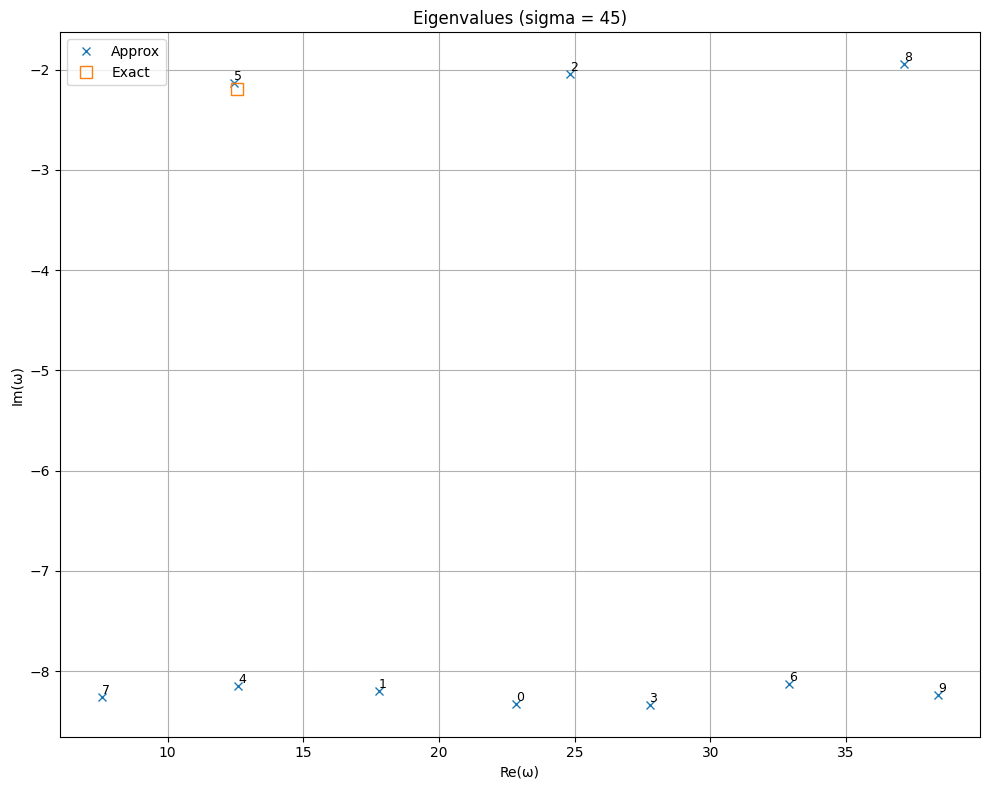

In [364]:
fig, ax = plt.subplots(figsize=(10, 8))


data = results_sigma[sigma][eigenvalue]

eig_approx = data['eig_approx']
eig_exact = data['eig_exact']

# Plot approximate eigenvalues
ax.plot(
    np.real(eig_approx), np.imag(eig_approx),
    marker='x', linestyle='none', fillstyle='none',
    label='Approx', markersize=6
)

# Number each approximate eigenvalue
for i, val in enumerate(eig_approx):
    ax.text(
        np.real(val), np.imag(val),
        str(i),
        fontsize=9,
        ha='left', va='bottom'
    )

# Plot exact eigenvalue
ax.plot(
    np.real(eig_exact), np.imag(eig_exact),
    marker='s', linestyle='none', fillstyle='none',
    label='Exact', markersize=8
)

ax.set_xlabel('Re(ω)')
ax.set_ylabel('Im(ω)')
ax.grid(True)
ax.legend()
ax.set_title(f'Eigenvalues (sigma = {sigma})')
plt.tight_layout()
plt.show()


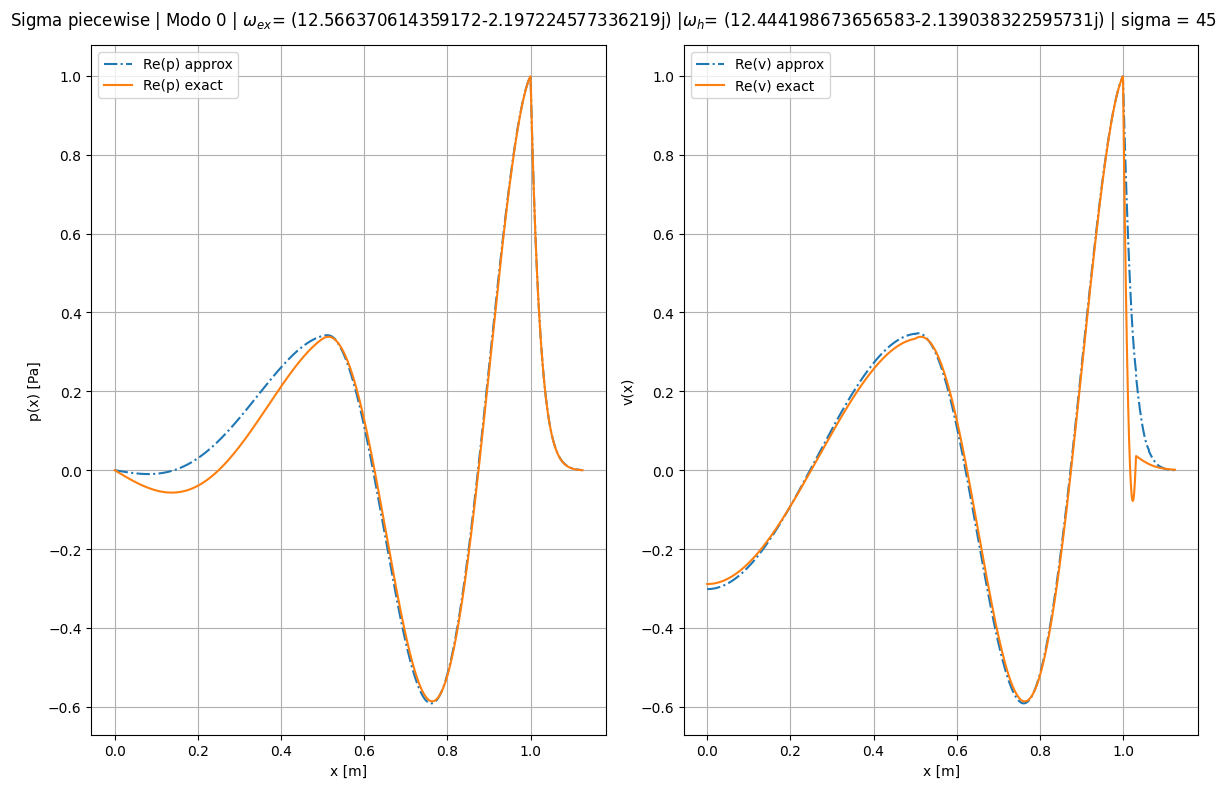

In [368]:
k=5
plot_mode_sigma(eig=eigenvalue, sigma_i=sigma, k=k, bb=bb)

In [369]:
data = results_sigma[sigma_i][eigenvalue]

err_total = data['err_total']
err_eig = data['err_eig']
err_p = data['err_p']
err_v = data['err_v']
print(f"Errors for sigma = {sigma_i}, mode {eigenvalue}:")
for i, err in enumerate(err_total):
    print(f"Mode {i}:")
    print(f"ε(ω)= {err_eig[i]:.3e}, ε(p)= {err_p[i]:.3e}, ε(v)= {err_v[i]:.3e}, ε(ω)+ε(p)+ε(v) = {err:.3e}$")


Errors for sigma = 199, mode 0:
Mode 0:
ε(ω)= 7.551e-01, ε(p)= 1.143e+00+0.000e+00j, ε(v)= 1.200e+00+0.000e+00j, ε(ω)+ε(p)+ε(v) = 3.098e+00+0.000e+00j$
Mode 1:
ε(ω)= 3.209e-01, ε(p)= 9.682e-01+0.000e+00j, ε(v)= 8.111e-01+0.000e+00j, ε(ω)+ε(p)+ε(v) = 2.100e+00+0.000e+00j$
Mode 2:
ε(ω)= 9.807e-01, ε(p)= 1.571e+00+0.000e+00j, ε(v)= 1.516e+00+0.000e+00j, ε(ω)+ε(p)+ε(v) = 4.068e+00+0.000e+00j$
Mode 3:
ε(ω)= 1.407e+01, ε(p)= 1.000e+00+0.000e+00j, ε(v)= 1.000e+00+0.000e+00j, ε(ω)+ε(p)+ε(v) = 1.607e+01+0.000e+00j$
Mode 4:
ε(ω)= 3.345e-02, ε(p)= 2.648e-01+0.000e+00j, ε(v)= 1.595e-01+0.000e+00j, ε(ω)+ε(p)+ε(v) = 4.578e-01+0.000e+00j$
Mode 5:
ε(ω)= 1.319e+00, ε(p)= 1.264e+00+0.000e+00j, ε(v)= 1.284e+00+0.000e+00j, ε(ω)+ε(p)+ε(v) = 3.867e+00+0.000e+00j$
Mode 6:
ε(ω)= 2.756e-01, ε(p)= 9.479e-01+0.000e+00j, ε(v)= 7.506e-01+0.000e+00j, ε(ω)+ε(p)+ε(v) = 1.974e+00+0.000e+00j$
Mode 7:
ε(ω)= 1.766e+00, ε(p)= 1.277e+00+0.000e+00j, ε(v)= 1.342e+00+0.000e+00j, ε(ω)+ε(p)+ε(v) = 4.385e+00+0.000e+00j$
Mode 8:


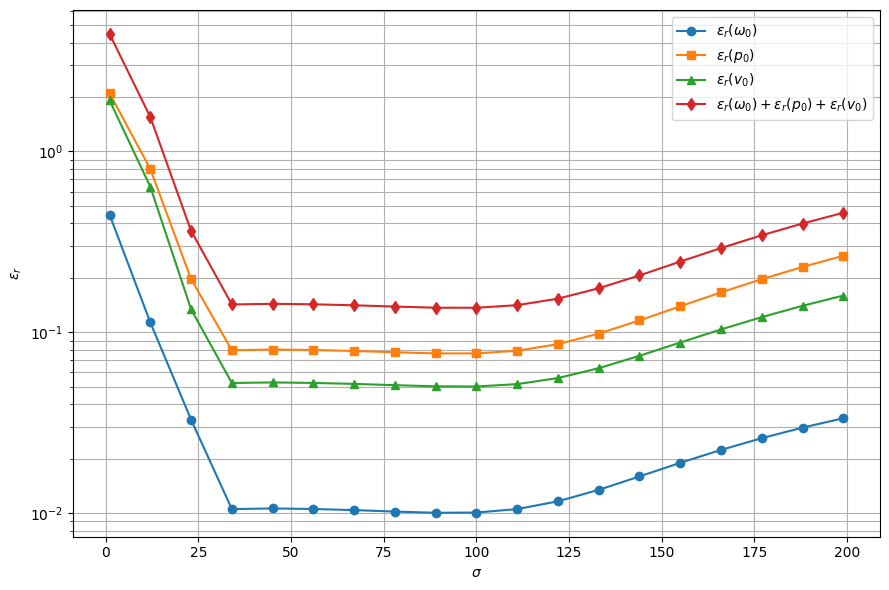

In [370]:
import numpy as np
import matplotlib.pyplot as plt

sigmas = []
err_eig = []
err_p = []
err_v = []
err_total = []

for sigma_i in sigma_sweep:
    data = results_sigma[sigma_i][eigenvalue]

    # índice do modo con menor erro total
    j_min = np.argmin(data['err_total'])

    sigmas.append(sigma_i)
    err_eig.append(data['err_eig'][j_min])
    err_p.append(data['err_p'][j_min])
    err_v.append(data['err_v'][j_min])
    err_total.append(data['err_total'][j_min])

sigmas = np.array(sigmas)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(sigmas, err_eig, marker='o', label=rf'$\epsilon_r(\omega_{eigenvalue})$')
ax.plot(sigmas, err_p, marker='s', label=rf'$\epsilon_r(p_{eigenvalue})$')
ax.plot(sigmas, err_v, marker='^', label=rf'$\epsilon_r(v_{eigenvalue})$')
ax.plot(sigmas, err_total, marker='d', label=rf'$\epsilon_r(\omega_{eigenvalue})+\epsilon_r(p_{eigenvalue})+\epsilon_r(v_{eigenvalue})$')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('$\epsilon_r$')
ax.set_yscale('log')
ax.grid(True, which='both')
ax.legend()

plt.tight_layout()
plt.show()
